In [14]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=30, centers=3, n_features=2)

import matplotlib.pyplot as plt


#plt.scatter(X[:,0], X[:,1], c=)
print(y)

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(y.reshape(-1,1))
T = enc.transform(y.reshape(-1,1)).toarray()
T = np.array(T)

[2 2 1 0 1 2 0 0 1 0 0 1 2 0 1 1 2 0 0 1 1 2 2 1 2 0 2 0 1 2]


In [13]:
np.shape(np.array(T))

(30, 3)

In [16]:
import numpy as np
from numpy.linalg import inv

Xtilde = np.hstack((np.ones((np.shape(X)[0],1)), X))

XX = np.matmul(Xtilde.T, Xtilde)
XT = np.matmul(Xtilde.T, T)

Beta = np.matmul(inv(XX), XT)
print(Beta)

[[-0.08085324  1.83348247 -0.75262924]
 [ 0.06980513 -0.2415361   0.17173097]
 [-0.07402843 -0.06157932  0.13560775]]


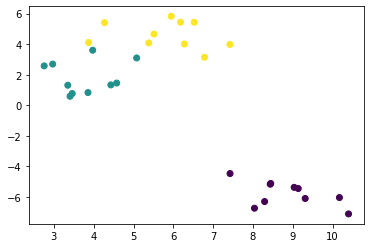

In [17]:
plt.scatter(X[:,0], X[:,1], c = y)
plt.show()

(3, 10000)


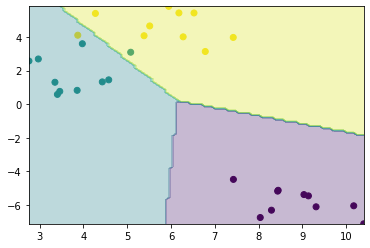

In [32]:
x1min = np.min(X[:,0])
x1max = np.max(X[:,0])
x2min = np.min(X[:,1])
x2max = np.max(X[:,1])

xx1, xx2 = np.meshgrid(np.linspace(x1min, x1max, 100), np.linspace(x2min, x2max, 100))

Xpredict = np.vstack((xx1.flatten(), xx2.flatten())).T

XtildePredict = np.hstack((np.ones((np.shape(Xpredict)[0],1)), Xpredict))

prediction = np.matmul(Beta.T,XtildePredict.T) 
print(np.shape(prediction))

predictedTargets = np.zeros((len(xx1.flatten()), 1))

for i in range(len(xx1.flatten())):
    
    predictedTargets[i] = numpy.argmax(prediction[:,i])
    

    
    
plt.scatter(X[:,0], X[:,1], c = y)
plt.contourf(xx1, xx2, np.reshape(predictedTargets,np.shape(xx1)), alpha = .3)
plt.show()